# 01 — EDA and Preprocessing

目标：
- 加载 Kaggle 数据集 (`erdemtaha/cancer-data`)，检查维度、缺失值、数据类型。
- 使用 `df.describe()` 与可视化（直方图、箱形图）识别分布特征、偏度/峰度。
- 精确计算并报告类别比例。
- 计算皮尔逊相关性热力图，列出绝对相关系数大于 0.9 的特征对。
- 固化分层 K 折交叉验证策略（StratifiedKFold, K=10, random_state=42），为后续建模一致使用。

In [3]:
import kagglehub
import os, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold

sns.set(style="whitegrid", context="notebook")
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 200)

## 下载并定位数据文件（使用你提供的 Kaggle 方式）

In [4]:
path = kagglehub.dataset_download("erdemtaha/cancer-data")
print("Path to dataset files:", path)
csv_files = glob.glob(os.path.join(path, "*.csv"))
print("Detected CSV files:", csv_files)
assert len(csv_files) > 0, "未检测到CSV文件。请检查数据集内容（可能是zip或不同文件结构）。"
csv_path = csv_files[0]
print("Using CSV:", csv_path)
df = pd.read_csv(csv_path)
print("Shape:", df.shape)
df.head()

Path to dataset files: /Users/jianglikai/.cache/kagglehub/datasets/erdemtaha/cancer-data/versions/1
Detected CSV files: ['/Users/jianglikai/.cache/kagglehub/datasets/erdemtaha/cancer-data/versions/1/Cancer_Data.csv']
Using CSV: /Users/jianglikai/.cache/kagglehub/datasets/erdemtaha/cancer-data/versions/1/Cancer_Data.csv
Shape: (569, 33)


,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


## 标签列确认
- 为避免臆断，这里只做保守自动识别：尝试常见列名，然后请你确认实际列名。
- 如果与实际不符，请在下方 `LABEL_COL` 手动修改为正确标签列。

In [5]:
candidate_label_cols = ["diagnosis", "target", "label", "Class", "class"]
LABEL_COL = None
for c in candidate_label_cols:
    if c in df.columns:
        LABEL_COL = c
        break
print("Auto-detected label column:", LABEL_COL)
assert LABEL_COL is not None, "请确认标签列名称（例如 'diagnosis' 或 'target'），并在此变量中设置。"

Auto-detected label column: diagnosis


## 1.1 数据勘探与净化：基本检查、缺失值、数据类型、描述统计

In [6]:
display(df.info())
display(df.describe(include='all'))

# 缺失值统计（仅打印有缺失的列）
missing_counts = df.isna().sum()
print("Missing values per column:\n", missing_counts[missing_counts > 0])

# 数值特征列选择：剔除无效列，并仅保留有非空值的数值列
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
num_cols = [c for c in num_cols if c not in ['id', 'Unnamed: 32']]
num_cols = [c for c in num_cols if df[c].notna().sum() > 0]
print("Numeric columns (count):", len(num_cols))
num_cols[:10]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

None

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
count,5.690000e+02,569,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,0.0
unique,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,357,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,3.037183e+07,NaN,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,0.405172,1.216853,2.866059,40.337079,0.007041,0.025478,0.031894,0.011796,0.020542,0.003795,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946,NaN
std,1.250206e+08,NaN,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,0.277313,0.551648,2.021855,45.491006,0.003003,0.017908,0.030186,0.006170,0.008266,0.002646,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061,NaN
min,8.670000e+03,NaN,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,0.111500,0.360200,0.757000,6.802000,0.001713,0.002252,0.000000,0.000000,0.007882,0.000895,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040,NaN
25%,8.692180e+05,NaN,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,0.232400,0.833900,1.606000,17.850000,0.005169,0.013080,0.015090,0.007638,0.015160,0.002248,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460,NaN
50%,9.060240e+05,NaN,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,0.324200,1.108000,2.287000,24.530000,0.006380,0.020450,0.025890,0.010930,0.018730,0.003187,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040,NaN
75%,8.813129e+06,NaN,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,0.478900,1.474000,3.357000,45.190000,0.008146,0.032450,0.042050,0.014710,0.023480,0.004558,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080,NaN


Missing values per column:
 Unnamed: 32    569
dtype: int64
Numeric columns (count): 30


['radius_mean',
 'texture_mean',
 'perimeter_mean',
 'area_mean',
 'smoothness_mean',
 'compactness_mean',
 'concavity_mean',
 'concave points_mean',
 'symmetry_mean',
 'fractal_dimension_mean']

 ##
 分布可视化：直方图（最多显示12个）

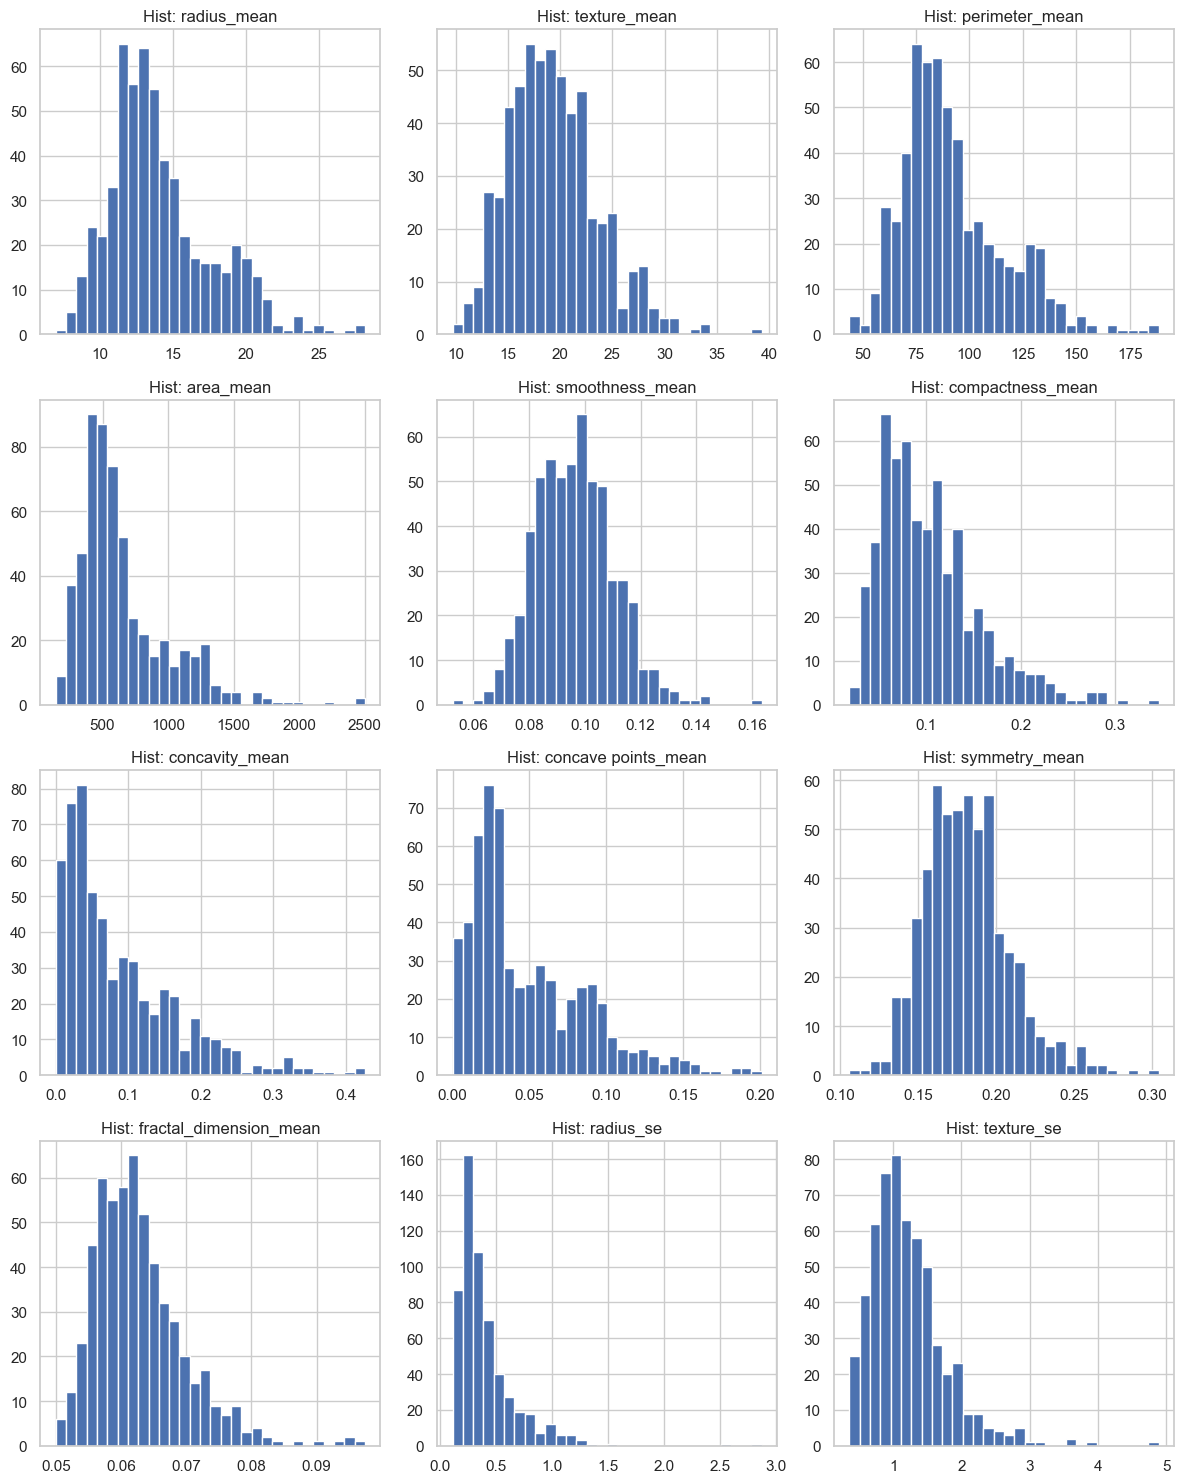

In [7]:
# 分布可视化：直方图（最多显示12个）
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", context="notebook")

n_show = min(12, len(num_cols))
fig, axes = plt.subplots(nrows=n_show//3 + (1 if n_show%3 else 0), ncols=3, figsize=(12, 3*(n_show//3 + 1)))
axes = axes.flatten()
for i, col in enumerate(num_cols[:n_show]):
    axes[i].hist(df[col].dropna(), bins=30, color="#4C72B0", edgecolor="white")
    axes[i].set_title(f"Hist: {col}")
plt.tight_layout()
plt.show()


### 数值特征列选择与分布可视化（直方图、箱形图）

/var/folders/h7/l0hj74bd2vqdz0r68qj78nd80000gn/T/ipykernel_3896/1355094849.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=LABEL_COL, y=col, data=df, ax=axes[i], palette=["#55A868", "#C44E52"])
/var/folders/h7/l0hj74bd2vqdz0r68qj78nd80000gn/T/ipykernel_3896/1355094849.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=LABEL_COL, y=col, data=df, ax=axes[i], palette=["#55A868", "#C44E52"])
/var/folders/h7/l0hj74bd2vqdz0r68qj78nd80000gn/T/ipykernel_3896/1355094849.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=LABEL_COL, y=col, 

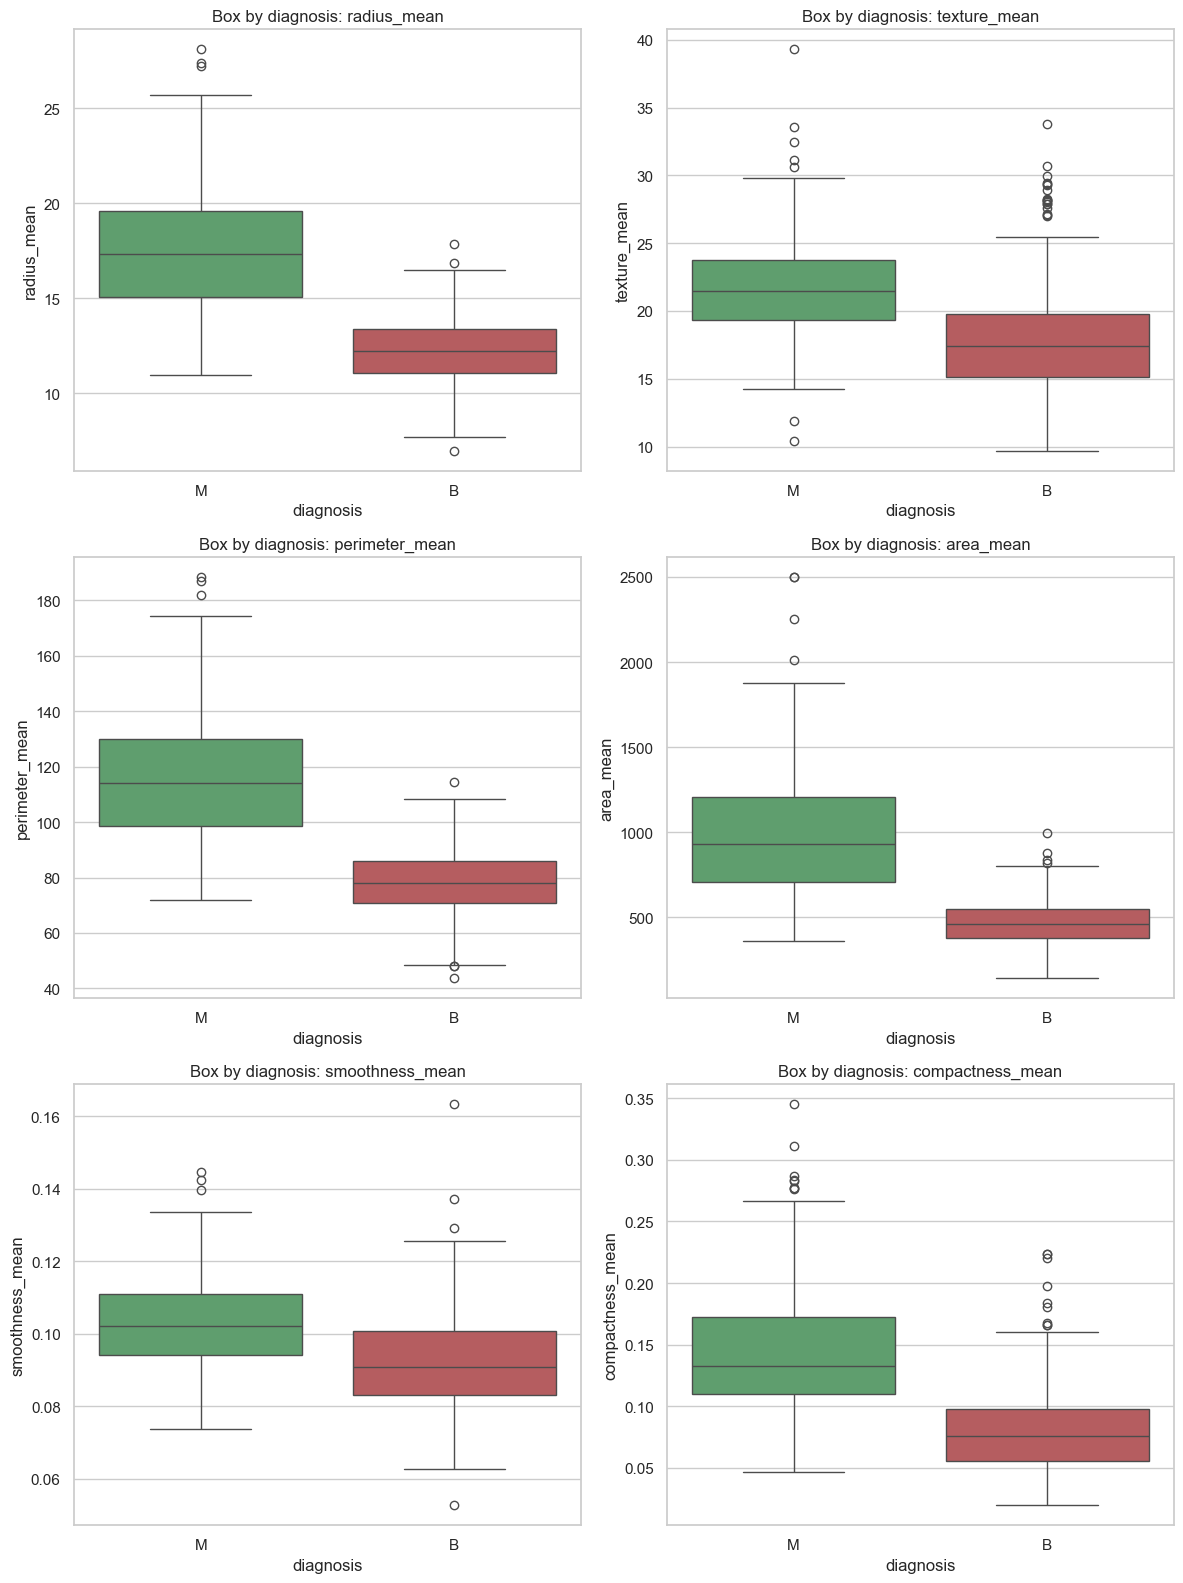

In [8]:
# 箱形图按标签分组（最多显示6个）
if LABEL_COL in df.columns:
    n_show = min(6, len(num_cols))
    fig, axes = plt.subplots(nrows=n_show//2 + (1 if n_show%2 else 0), ncols=2, figsize=(12, 4*(n_show//2 + 1)))
    axes = axes.flatten()
    for i, col in enumerate(num_cols[:n_show]):
        sns.boxplot(x=LABEL_COL, y=col, data=df, ax=axes[i], palette=["#55A868", "#C44E52"])
        axes[i].set_title(f"Box by {LABEL_COL}: {col}")
    plt.tight_layout()
    plt.show()

### 偏度与峰度

In [9]:
skew_kurt = pd.DataFrame({
    "skew": df[num_cols].skew(),
    "kurtosis": df[num_cols].kurtosis()
})
skew_kurt.sort_values(by="skew", key=lambda s: s.abs(), ascending=False).head(10)

,skew,kurtosis
area_se,5.447186,49.209077
concavity_se,5.110463,48.861395
fractal_dimension_se,3.923969,26.280847
perimeter_se,3.443615,21.401905
radius_se,3.088612,17.686726
smoothness_se,2.314450,10.469840
symmetry_se,2.195133,7.896130
compactness_se,1.902221,5.106252
area_worst,1.859373,4.396395
fractal_dimension_worst,1.662579,5.244611


## 1.1.2 类别不平衡分析：良性(B)/恶性(M)比例（或 0/1、False/True）

In [10]:
vc = df[LABEL_COL].value_counts(dropna=False)
total = vc.sum()
ratios = (vc / total).rename("ratio")
print("Counts:\n", vc)
print("Ratios:\n", ratios)

Counts:
 diagnosis
B    357
M    212
Name: count, dtype: int64
Ratios:
 diagnosis
B    0.627417
M    0.372583
Name: ratio, dtype: float64


## 1.1.3 皮尔逊相关性热力图 + 绝对相关系数 > 0.9 的特征对列表
- 注意：这里只计算数值列间的皮尔逊相关性。

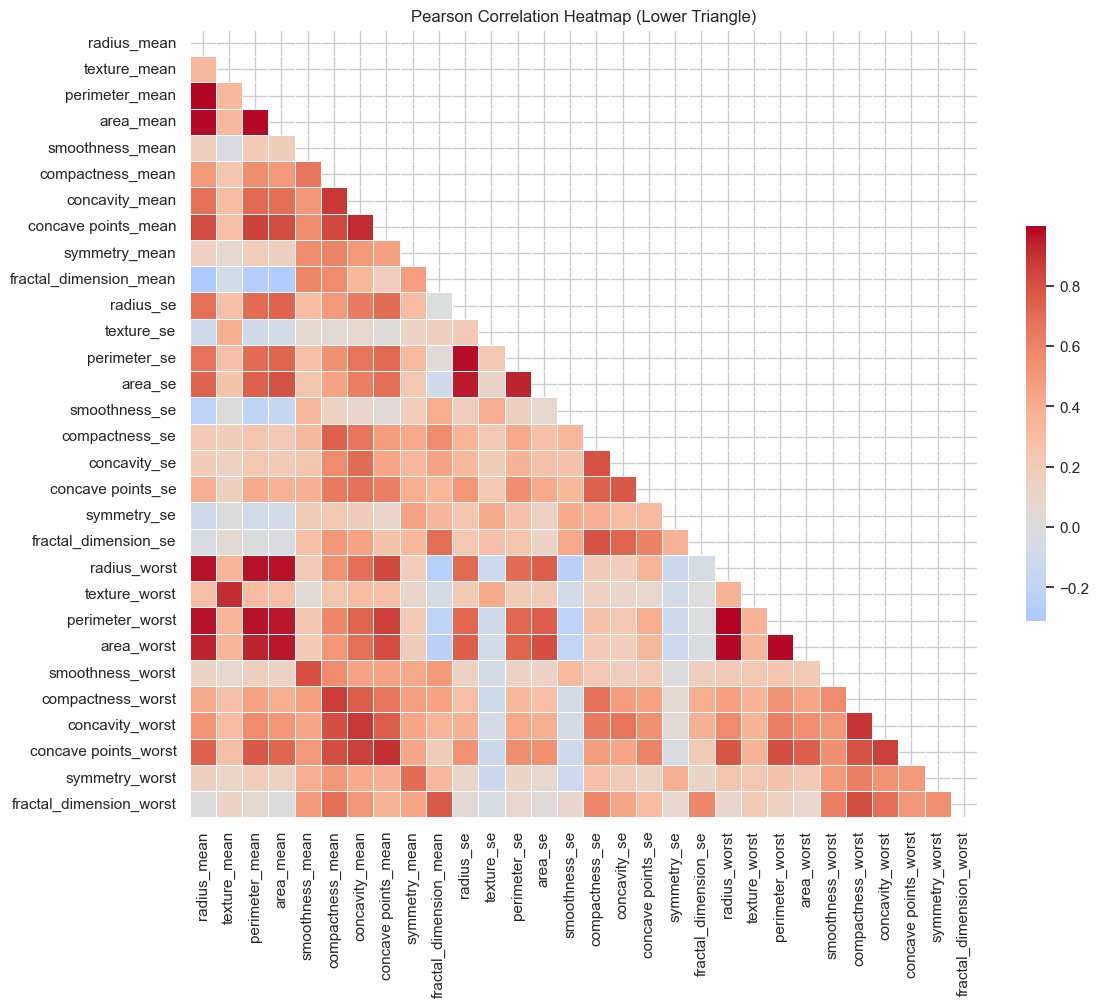

,feature_1,feature_2,correlation
0,radius_mean,perimeter_mean,0.997855
18,radius_worst,perimeter_worst,0.993708
1,radius_mean,area_mean,0.987357
6,perimeter_mean,area_mean,0.986507
19,radius_worst,area_worst,0.984015
20,perimeter_worst,area_worst,0.977578
15,radius_se,perimeter_se,0.972794
8,perimeter_mean,perimeter_worst,0.970387
2,radius_mean,radius_worst,0.969539
7,perimeter_mean,radius_worst,0.969476


In [13]:

# 1.1.3 — 皮尔逊相关性热力图 + 高相关特征对（|r|≥0.9）
# 使用上面筛选后的 num_cols
corr = df[num_cols].corr(method='pearson')

# 绘制并保存热力图
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(12, 10))
sns.heatmap(corr, mask=mask, cmap="coolwarm", center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title("Pearson Correlation Heatmap (Lower Triangle)")
plt.tight_layout()

import os
out_dir = "/Users/jianglikai/Documents/trae_projects/SC4020/Task3"
os.makedirs(out_dir, exist_ok=True)
plt.savefig(os.path.join(out_dir, "pearson_corr_heatmap.png"), dpi=150)
plt.show()

# 计算高相关特征对列表并保存为CSV
pairs = []
cols = corr.columns.tolist()
for i in range(len(cols)):
    for j in range(i + 1, len(cols)):
        r = corr.iloc[i, j]
        if abs(r) >= 0.9:
            pairs.append({"feature_1": cols[i], "feature_2": cols[j], "correlation": float(r)})

high_corr_df = pd.DataFrame(pairs).sort_values(by="correlation", key=lambda s: s.abs(), ascending=False)
high_corr_df.to_csv(os.path.join(out_dir, "high_corr_pairs.csv"), index=False)

# 显示前20行以便交互查看
high_corr_df.head(20)


## 1.2. 发现与洞察：严重的多重共线性

正如相关性热力图和网络图所示，数据集中存在严重的**多重共线性**。许多特征对（如 `radius_mean` 和 `perimeter_mean`）的相关性系数接近1，形成紧密的特征簇。

**主要发现:**
- **几何特征高度冗余:** 大部分与肿瘤大小（半径、周长、面积）相关的特征高度相关。
- **'mean'、'se' 和 'worst' 之间的强关联:** 同一基本测量的不同统计量（例如 `radius_mean`, `radius_se`, `radius_worst`）之间也存在强烈的线性关系。

**对建模的影响:**
1.  **模型不稳定性:** 线性模型（如逻辑回归）的系数会变得不稳定且难以解释。
2.  **特征重要性失真:** 基于树的模型（如随机森林、XGBoost）的特征重要性可能会被稀释或在共线特征之间随机分配。
3.  **过拟合风险:** 虽然不直接导致过拟合，但冗余特征会增加模型复杂性。

**应对策略:**
- **特征选择:** 我们将探索基于过滤（如移除一个高相关对中的特征）和嵌入方法来选择一个更小的、信息量大的特征子集。
- **模型选择:** 使用对共线性不敏感的模型，或使用正则化（如Ridge）来减轻其影响。
- **可解释性分析:** 我们将利用 SHAP 分析来比较在完整特征集和去相关特征集上训练的模型的行为，以探究多重共线性如何影响模型决策的解释。

接下来，我们将定义我们的实验评估框架。

In [12]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
framework = {
    "cv_strategy": "StratifiedKFold",
    "cv_params": {"n_splits": 10, "shuffle": True, "random_state": 42},
    "primary_metric": "Recall",
    "core_comparison_metric": "PR-AUC",
    "aux_metrics": ["F1", "Precision", "ROC-AUC"]
}
framework

{'cv_strategy': 'StratifiedKFold',
 'cv_params': {'n_splits': 10, 'shuffle': True, 'random_state': 42},
 'primary_metric': 'Recall',
 'core_comparison_metric': 'PR-AUC',
 'aux_metrics': ['F1', 'Precision', 'ROC-AUC']}